# PySpark Machine Learning


https://spark.apache.org/docs/latest/ml-pipeline.html


In machine learning, it's common to run a series of steps for data prep, cleansing, feature engineering, and then ultimately model training (among several other potential steps).

Spark ML Pipelines sequences these steps into an ordered array (or DAG). A Pipeline is specified as a sequence of stages, and each stage is either a Transformer or an Estimator.

It's often a best practice to save a model or a pipeline to disk for later use.

Below is an example Spark ML Pipeline that shows two Transformers (Tokenizer and HashingTF) and one Estimator (Logistic Regression).
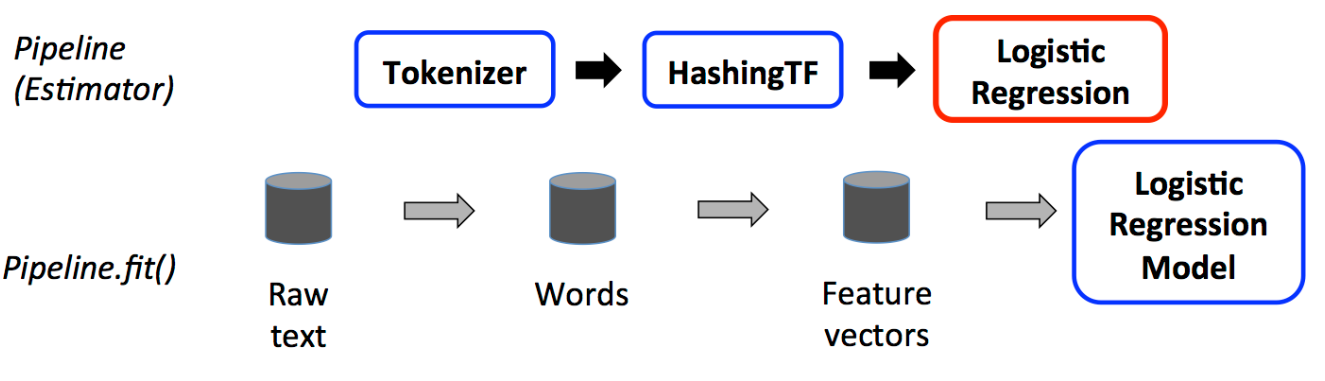

## Install Spark Dependencies

In [ ]:
# Install Spark dependencies
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!rm spark-3.2.3-bin-hadoop3.2.tgz
!wget --no-cookies --no-check-certificate https://dlcdn.apache.org/spark/spark-3.2.3/spark-3.2.3-bin-hadoop3.2.tgz
!tar zxvf spark-3.2.3-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark==3.2.3

In [2]:
!ls -al | grep spark

drwxr-xr-x 13  501 1000      4096 Nov 14 17:54 spark-3.2.3-bin-hadoop3.2
-rw-r--r--  1 root root 301136158 Nov 14 18:47 spark-3.2.3-bin-hadoop3.2.tgz


## Import Python and PySpark Libraries

In [3]:
# Set up required environment variables
import os
os.environ["JAVA_HOME"]  = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.3-bin-hadoop3.2"

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer

## Initialize Spark Session

In [4]:
spark = SparkSession.builder.appName("Spark ML Pipeline Example").master("local[*]").getOrCreate()

## Load Sample Data

In [5]:
training = spark.createDataFrame([
    (0, "a b c d e spark", 1.0),
    (1, "b d", 0.0),
    (2, "spark f g h", 1.0),
    (3, "hadoop mapreduce", 0.0)
], ["id", "text", "label"])

In [7]:
training.show(10,False)

+---+----------------+-----+
|id |text            |label|
+---+----------------+-----+
|0  |a b c d e spark |1.0  |
|1  |b d             |0.0  |
|2  |spark f g h     |1.0  |
|3  |hadoop mapreduce|0.0  |
+---+----------------+-----+



## Configure Pipeline Objects

Transforms (tokenizer and hashingTF) and Estimators (logistic regression)

In [9]:
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.001)

In [10]:
tokenizer.transform(training).show(5, False)

+---+----------------+-----+----------------------+
|id |text            |label|words                 |
+---+----------------+-----+----------------------+
|0  |a b c d e spark |1.0  |[a, b, c, d, e, spark]|
|1  |b d             |0.0  |[b, d]                |
|2  |spark f g h     |1.0  |[spark, f, g, h]      |
|3  |hadoop mapreduce|0.0  |[hadoop, mapreduce]   |
+---+----------------+-----+----------------------+



## Create Pipeline Object

In [11]:
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])

## Run Pipeline to transform data and train model

In [12]:
model = pipeline.fit(training)

In [13]:
model.stages

[Tokenizer_2ae7197366ba,
 HashingTF_a118e0d74f67,
 LogisticRegressionModel: uid=LogisticRegression_bedc81fec806, numClasses=2, numFeatures=262144]

## Test Model

In [14]:
test = spark.createDataFrame([
    (4, "spark i j k"),
    (5, "l m n"),
    (6, "spark hadoop spark"),
    (7, "apache hadoop")
], ["id", "text"])

# Make predictions on test documents and print columns of interest.
prediction = model.transform(test)
prediction.show(10,False)

+---+------------------+----------------------+------------------------------------------------------+----------------------------------------+-----------------------------------------+----------+
|id |text              |words                 |features                                              |rawPrediction                           |probability                              |prediction|
+---+------------------+----------------------+------------------------------------------------------+----------------------------------------+-----------------------------------------+----------+
|4  |spark i j k       |[spark, i, j, k]      |(262144,[19036,68693,173558,213660],[1.0,1.0,1.0,1.0])|[0.5288285522796805,-0.5288285522796805]|[0.6292098489668488,0.37079015103315116] |0.0       |
|5  |l m n             |[l, m, n]             |(262144,[1303,52644,248090],[1.0,1.0,1.0])            |[4.1691413953400565,-4.1691413953400565]|[0.9847700067623042,0.015229993237695805]|0.0       |
|6  |spark hado

In [15]:
selected = prediction.select("id", "text", "probability", "prediction")
for row in selected.collect():
   rid, text, prob, prediction = row
   print("(%d, %s) --> prob=%s, prediction=%f" % (rid, text, str(prob), prediction))

(4, spark i j k) --> prob=[0.6292098489668488,0.37079015103315116], prediction=0.000000
(5, l m n) --> prob=[0.9847700067623042,0.015229993237695805], prediction=0.000000
(6, spark hadoop spark) --> prob=[0.13412348342566116,0.8658765165743388], prediction=1.000000
(7, apache hadoop) --> prob=[0.9955732114398529,0.00442678856014711], prediction=0.000000
